In [1]:
import psycopg
from psycopg import sql
import importlib
import config
importlib.reload(config)
import pandas as pd
from typing import List, Dict, Any, Mapping, Tuple
from datetime import datetime
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

In [8]:
with open('/home/pjtl2w01admin/csm/VizTool_pjt/network_graph/graph_json.json', 'r') as f:
    graph_json = json.load(f)

### 계층 및 그래프 구성

#### 1. 계층 구조 조성 (Group > Attr > Node)

In [10]:
def build_filter_hierarchy(graph_data):
    hierarchy = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))

    for node in graph_data['nodes']:
        group = node['data']['parent']  #group
        label = node['data']['label']   #node

        for attr, value in node['data'].items(): #attributes
            if attr not in ['parent', 'label']:
                hierarchy[group][attr][value].add(label)
    
    return hierarchy

In [11]:
hierarchy = build_filter_hierarchy(graph_json)
print(json.dumps(hierarchy, indent=2, default=list))

{
  "C": {
    "doc_no": {
      "0000000001": [
        "Sales Order 1"
      ],
      "0000000002": [
        "Sales Order 2"
      ],
      "0000000003": [
        "Sales Order 3"
      ],
      "0000000004": [
        "Sales Order 4"
      ],
      "0000000005": [
        "Sales Order 5"
      ]
    },
    "item": {
      "10": [
        "Sales Order 5",
        "Sales Order 1",
        "Sales Order 3",
        "Sales Order 4"
      ],
      "20": [
        "Sales Order 2"
      ]
    },
    "material": {
      "FERT001": [
        "Sales Order 1"
      ],
      "FERT002": [
        "Sales Order 2"
      ],
      "FERT003": [
        "Sales Order 3"
      ],
      "COMP001": [
        "Sales Order 4"
      ],
      "FERT005": [
        "Sales Order 5"
      ]
    },
    "description": {
      "GRANDEUR": [
        "Sales Order 1"
      ],
      "SONATA": [
        "Sales Order 2"
      ],
      "IONIQ": [
        "Sales Order 3"
      ],
      "BATTERY PACK": [
        "Sales Order

#### 2. 역색인 생성

In [8]:
def build_reverse_index(hierarchy):
    index = defaultdict(set)

    for group, group_data in hierarchy.items():
        for attr, attr_data in group_data.items():
            all_nodes = {n for nodes in attr_data.values() for n in nodes}
            # 1. 그룹 단위
            index[(group,)].update(all_nodes)

            # 2. 그룹 + 속성 단위
            index[(group, attr)].update(all_nodes)

            # 3. 속성 단위
            index[(attr,)].update(all_nodes)
        
    return index

역색인 저장 / 로드

In [ ]:
#메인 함수에서...
# reversed_index = build_reverse_index 먼저 선행

In [3]:
def save_index(index, path='./reverse_index.pkl'):
    with open(path, 'wb') as f:
        pickle.dump(index, f)

In [4]:
def load_index(path='./reverse_index.pkl'):
    with open(path, 'rb') as f:
        return pickle.load(f)

#### 3. 네트워크 데이터로 변환

In [12]:
nodes = graph_json['nodes']
edges = graph_json['edges']

print(len(nodes), "nodes loaded")
print(len(edges), "edges loaded")

25 nodes loaded
20 edges loaded


In [13]:
nodes_df = pd.DataFrame(nodes)
nodes_df

,id,data
0,C-10,"{'parent': 'C', 'label': 'Sales Order 1', 'doc..."
1,J-10,"{'parent': 'J', 'label': 'Outbound Delivery 1'..."
2,R-10,"{'parent': 'R', 'label': 'Goods Issue 1', 'doc..."
3,M-10,"{'parent': 'M', 'label': 'Invoice 1', 'doc_no'..."
4,E-10,"{'parent': 'E', 'label': 'Journal Entry 1', 'd..."
5,C-20,"{'parent': 'C', 'label': 'Sales Order 2', 'doc..."
6,J-20,"{'parent': 'J', 'label': 'Outbound Delivery 2'..."
7,R-20,"{'parent': 'R', 'label': 'Goods Issue 2', 'doc..."
8,M-20,"{'parent': 'M', 'label': 'Invoice 2', 'doc_no'..."
9,E-20,"{'parent': 'E', 'label': 'Journal Entry 2', 'd..."


In [14]:
edges_df = pd.DataFrame(edges)
edges_df

,source,target,id,data
0,C-10,J-10,C10_J10,{'label': 'Delivery Creation'}
1,J-10,R-10,J10_R10,{'label': 'Post Goods Issue'}
2,R-10,M-10,R10_M10,{'label': 'Billing'}
3,M-10,E-10,M10_E10,{'label': 'Accounting Posting'}
4,C-20,J-20,C20_J20,{'label': 'Delivery Creation'}
5,J-20,R-20,J20_R20,{'label': 'Post Goods Issue'}
6,R-20,M-20,R20_M20,{'label': 'Billing'}
7,M-20,E-20,M20_E20,{'label': 'Accounting Posting'}
8,C-30,J-30,C30_J30,{'label': 'Delivery Creation'}
9,J-30,R-30,J30_R30,{'label': 'Post Goods Issue'}


In [15]:
#방향 그래프 구성
G = nx.DiGraph()

#노드 추가
for _, row in nodes_df.iterrows():
    attrs = row['data'].copy()
    G.add_node(row['id'], **attrs)

#엣지 추가
for _, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], label=row.get('id'))

In [16]:
print('총 노드 수:', G.number_of_nodes())
print('총 엣지 수:', G.number_of_edges())

총 노드 수: 25
총 엣지 수: 20


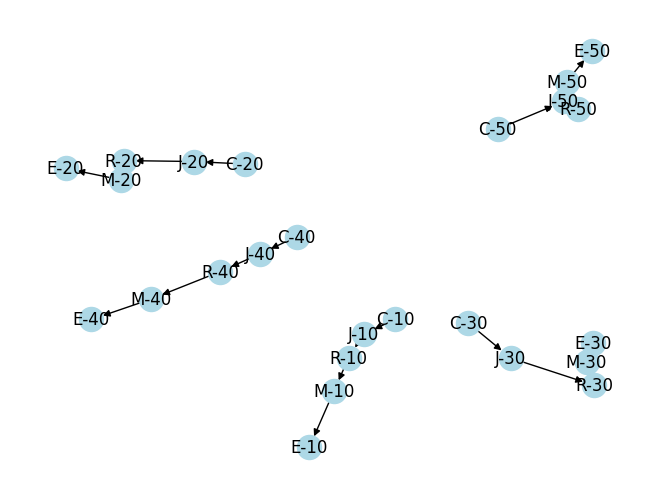

In [17]:
# 그래프 그리기
nx.draw(G, with_labels=True, node_color='lightblue')
plt.show()

그래프 빌드

In [18]:
# 위 내용 함수화 
def build_graph(nodes, edges):
    """노드/엣지 리스트를 받아 Networkx DiGraph 생성"""
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node['id'], **node.get('attributes', {}))
    for edge in edges:
        G.add_edge(edge['source'], edge['target'], **edge)
    return G

그래프 그리기

In [19]:
def draw_graph(G):
    nx.draw(G, with_labels=True, node_color='lightblue')
    plt.show()

서브 그래프 만들기

In [20]:
def build_subgraph(G, node_ids):
    """특정 노드들만 포함하는 서브그래프 반환"""
    #필터링된 노드들만 포함된 부분 그래프를 만들고 싶다면 node_ids = filtered['id'].tolist()를 선행
    subG = G.subgraph(node_ids).copy()
    return subG

----

### 종속 필터링

1. 그룹 리스트

In [22]:
def list_groups(hierarchy):
    return sorted(list(hierarchy.keys()))

2. 속성 리스트

In [23]:
def list_attributes(hieararchy, groups=None):
    if not groups:
        return sorted(
            set(attr for group, group_attr in hieararchy.items() for attr in group_attr.keys())
        )
    
    attributes = set()
    for g in groups:
        group_attr = hieararchy.get(g, {})
        attributes.update(group_attr.keys())
        
    return sorted(attributes)

3. Value 리스트

In [ ]:
def list_values(hierarchy, groups=None, attributes=None):
    values = set()

    # 그룹이 선택되지 않은 경우
    if not groups:
        if not attributes: 
            for g_data in hierarchy.values():
                for attr_data in g_data.values(): #중복 A
                    values.update(str(key) for key in attr_data.keys()) 
            return sorted(values)

        for g_data in hierarchy.values():
            for attr in attributes:
                if attr in g_data:
                    attr_data = g_data[attr]
                    values.update(str(key) for key in attr_data.keys())
        return sorted(values)
    
    #그룹만 지정되어 있는 경우
    if not attributes:
        for g in groups:
            group_data = hierarchy.get(g, {})
            for attr_data in group_data.values(): #중복 A
                values.update(str(key) for key in attr_data.keys())
        return sorted(values)
        
    
    #그룹과 속성 모두 지정된 경우
    for g in groups:
        group_data = hierarchy.get(g, {})
        for attr in attributes:
            attr_data = group_data.get(attr, {})  #증복 A
            values.update(str(key) for key in attr_data.keys())
    
    return sorted(values)

기타 : Operator

In [5]:
def _run_operation(attr_value, target_value, operator):
    if operator in ("equal", "=", None):
        return str(attr_value) == str(target_value)
    if operator in ("greater", ">"):
        try:
            return float(attr_value) > float(target_value)
        except ValueError:
            return False
    if operator in ("lower", "<"):
        try:
            return float(attr_value) < float(target_value)
        except ValueError:
            return False
    if operator in ("contains", "in"):
        return str(target_value) in str(attr_value)
    return False

4. 노드 리스트

In [26]:
# 아무런 상위 항목이 정해지지 않은 경우
def list_all_nodes(graph_json):
    return sorted([n["data"]["label"] for n in graph_json.get("nodes", [])])

In [ ]:
def filter_nodes(hierarchy, index, groups=None, attributes=None):
    result = set()
    groups = groups or []
    attributes = attributes or []

    # 1. 그룹만 지정된 경우 : 역색인 사용
    if groups and not attributes:
        for g in groups:
            result.update(index.get((g,), set()))
        return sorted(result)
    
    # 2. 속성만 지정된 경우 : 역색인 사용
    if not groups and attributes:
        for cond in attributes:
            attr = cond.get("attribute")
            result.update(index.get((attr,), set()))
        return sorted(result)
    
    # 3. 그룹 + 속성 조합
    if groups and attributes:
        for g in groups:
            for cond in 

----

### 경로 탐색

#### Node Exploration

#### Path Search